# DSCI 100 - Individual Project Portion - Nicholas Huang, Section 3, Group 8

# 1 | Data Description

## Descriptive Summary of Dataset

players.csv has 196 rows and 7 columns / variables of information, with delimiter ",". These variables are:

| Variable   | Description                                                       | Data Type |
|------------|-------------------------------------------------------------------|-----------|
|experience  |The amount of experience a player has                              |character  |
|subscribe   |If the player is subscribed to a game related newsletter           |logical    |
|hashedEmail |Conversion of the player's email into a unique string of characters|character  | 
|played_hours|Number of hours the player has played on the PLAICraft.ai server   |double     |
|name        |The name of the player                                             |character  |
|gender      |The gender of the player                                           |character  |
|Age         |The age of the player                                              |double     |

sessions.csv has 1535 rows and 5 columns / variables of information, with delimiter ",". These variables are:

| Variable           | Description                                                       | Data Type |
|--------------------|-------------------------------------------------------------------|-----------|
|hashedEmail         |Conversion of the player's email into a unique string of characters|character  | 
|start_time          |The start time of that particular play session, in dd/mm/yyyy hh:mm|character  |
|end_time            |The end time of that particular play session, in dd/mm/yyyy hh:mm  |character  |
|original_start_time |Start time, formatted as UNIX epoch time in milliseconds           |double     |
|original_end_time   |End time, formatted as UNIX epoch time in milliseconds             |double     |

there are 4 quantitative variables (identified by R) across both datasets, and the means of those variables are reported below:
| Variable           | Mean            |                                          
|--------------------|-----------------|
|played_hours        |5.85             |
|Age                 |21.14            |
|original_start_time |1.72e+12         |
|original_end_time   |1.72e+12         |

Work for computing these are found below, in Section 3 - Computing the mean of the quantitative variables for each dataset


## Problems

There are a few problems within each dataset that immediately stand out:
- the fact that "experience" is vague, and can often be subjective when it comes to playing games. Hard to quantify or reliably compare between different experience levels when they aren't put on a clear scale
- within the "sessions" dataset, we are only given the hashedEmail, and no other identifier tools. This means that, if we wanted to utilize the sessions dataset alongside the players dataset, we would need to match the hashedEmail identifier to each player in order to identify them
- the "start time" and "end time" variables are read into R as characters, as it is not provided in the standard ISO 8601 date time format that R recognizes. This means that to make use of it with our tidymodels tools, such as applying functions like "filter" onto it or visualizing it, we would need to manually convert its type into date-time, or another useful format for us.
- the "original start time" and "original end time" are not provided in formats that are easily interpretable or useful
- experience and gender are read in as characters, but are categorical variables

These are just some prevalent problems when initially viewing the dataset. Additional problems will likely surface in the process of data analysis.

# 2 | Questions

## Broad Question Chosen

What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

### Specific Question

Can a player's age and number of hours played on the server predict whether they are subscribed to any game related newsletters?

The "players" dataset will clearly address this question of interest, as it provides data on the age of a player, hours they played on the server, and whether they are subscribed to game related newsletters.

Firstly, I would have to:
1. wrangle the players data set in order to select the columns of interest: "Age," "played_hours," and "subscribe."
2. standardize the variables, by applying appropriate centering and scaling functions to it.
3. apply K-NN classification methods we learned in class to this dataset in order to achieve some sort of predictive model, using age and hours played as the predictors, and subscription status as the response variable

# 3 | Exploratory Data Analysis and Visualization

## Loading data into R and wrangling

In [1]:
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

**Reading in players and session data using link directly from GitHub**

In [2]:
session_url <- "https://raw.githubusercontent.com/nhuang07/dsci_project_8/refs/heads/main/data/sessions.csv"
players_url <- "https://raw.githubusercontent.com/nhuang07/dsci_project_8/refs/heads/main/data/players.csv"

players <- read_csv(players_url)
session <- read_csv(session_url)

head(players)
head(session)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


**Tidying the data**

As the "sessions" dataset is not useful for my chosen question, I will not be including wrangling work to tidy it.

In [3]:
# dataset is already tidy - changing appropriate variable types to factor

players <- players |>
                mutate(experience = as_factor(experience)) |>
                mutate(gender = as_factor(gender))
head(players)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


**Computing the mean of the quantitative variables for the datasets**

In [4]:
# for players dataset

mean_players <- players |>
                    select(played_hours, Age) |>
                    map_df(mean, na.rm = TRUE)
mean_players 

# for sessions dataset

mean_session <- session |>
                    select(original_start_time, original_end_time) |>
                    map_df(mean, na.rm = TRUE)
mean_session

played_hours,Age
<dbl>,<dbl>
5.845918,21.13918


original_start_time,original_end_time
<dbl>,<dbl>
1.719201e+12,1.719196e+12


In its current format, the mean of the original start time and original end time is not useful for us. If used, it will likely need to be converted.

**Exploratory visualization of the data**

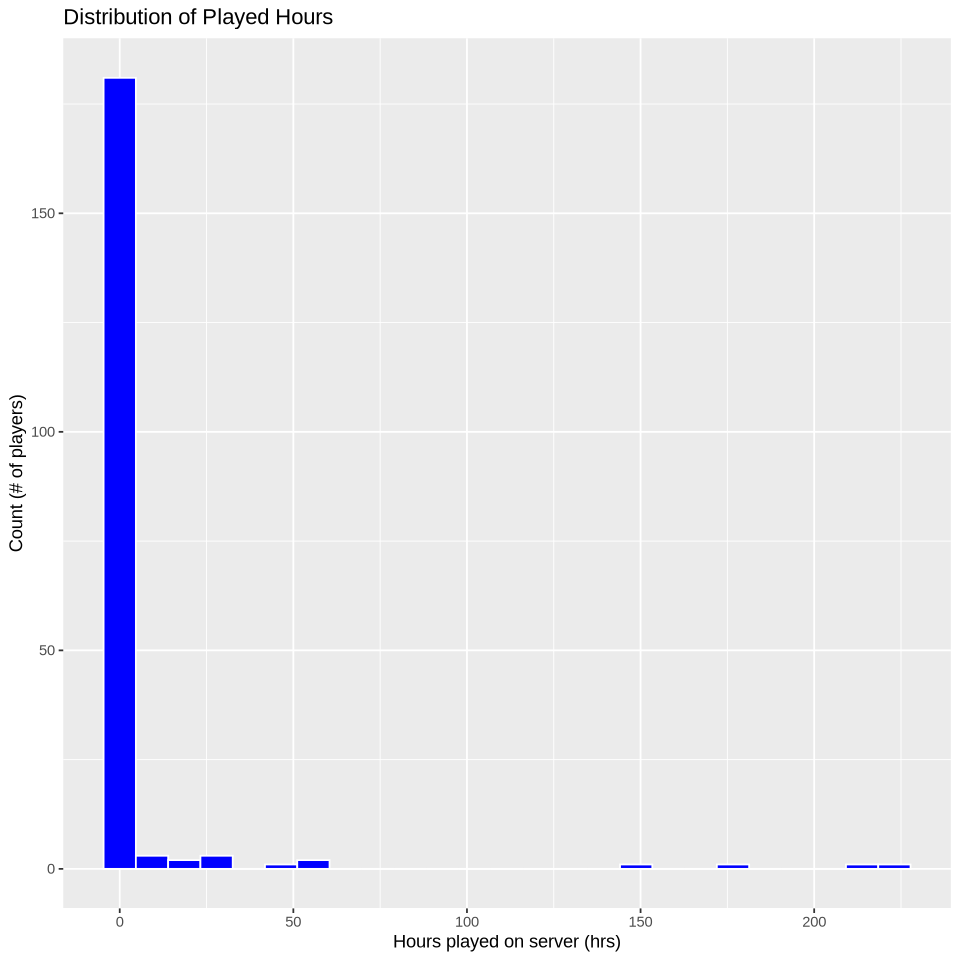

In [5]:
# distribtuion of played hours plot

options(repr.plot.width = 8, repr.plot.height = 8)

played_hours_plot <- ggplot(players, aes(x = played_hours)) +
                      geom_histogram(bins = 25, fill = "blue", color = "white") +
                      labs(title = "Distribution of Played Hours", 
                           x = "Hours played on server (hrs)", 
                           y = "Count (# of players)")
played_hours_plot

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


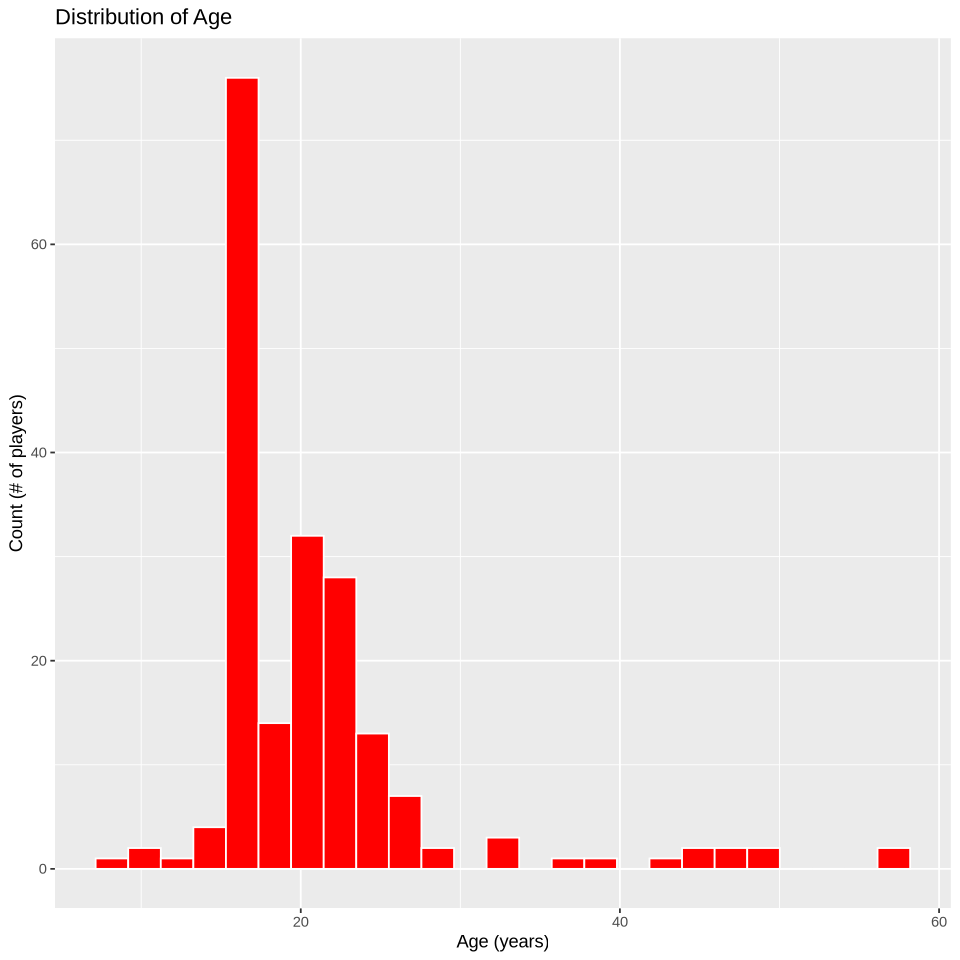

In [6]:
# distribution of age plot

options(repr.plot.width = 8, repr.plot.height = 8)

age_plot <- ggplot(players, aes(x = Age)) +
                      geom_histogram(bins = 25, fill = "red", color = "white") +
                      labs(title = "Distribution of Age", 
                           x = "Age (years)", 
                           y = "Count (# of players)")
age_plot

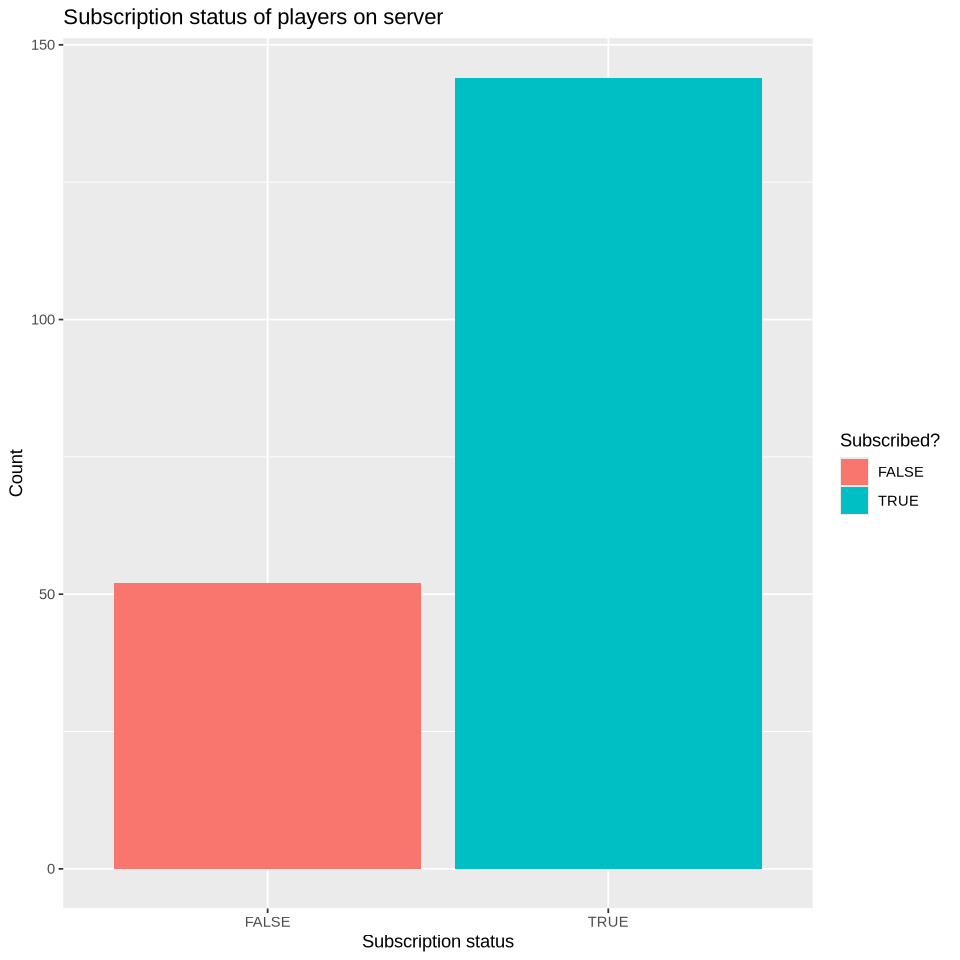

In [11]:
# bar plot of subscription, with height of bars being the # of each

options(repr.plot.width = 8, repr.plot.height = 8)

subscription_plot <- ggplot(players, aes(x = subscribe, fill = subscribe)) +
                        geom_bar() +
                        labs(title = "Subscription status of players on server",
                             x = "Subscription status",
                             y = "Count",
                             fill = "Subscribed?")
subscription_plot

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


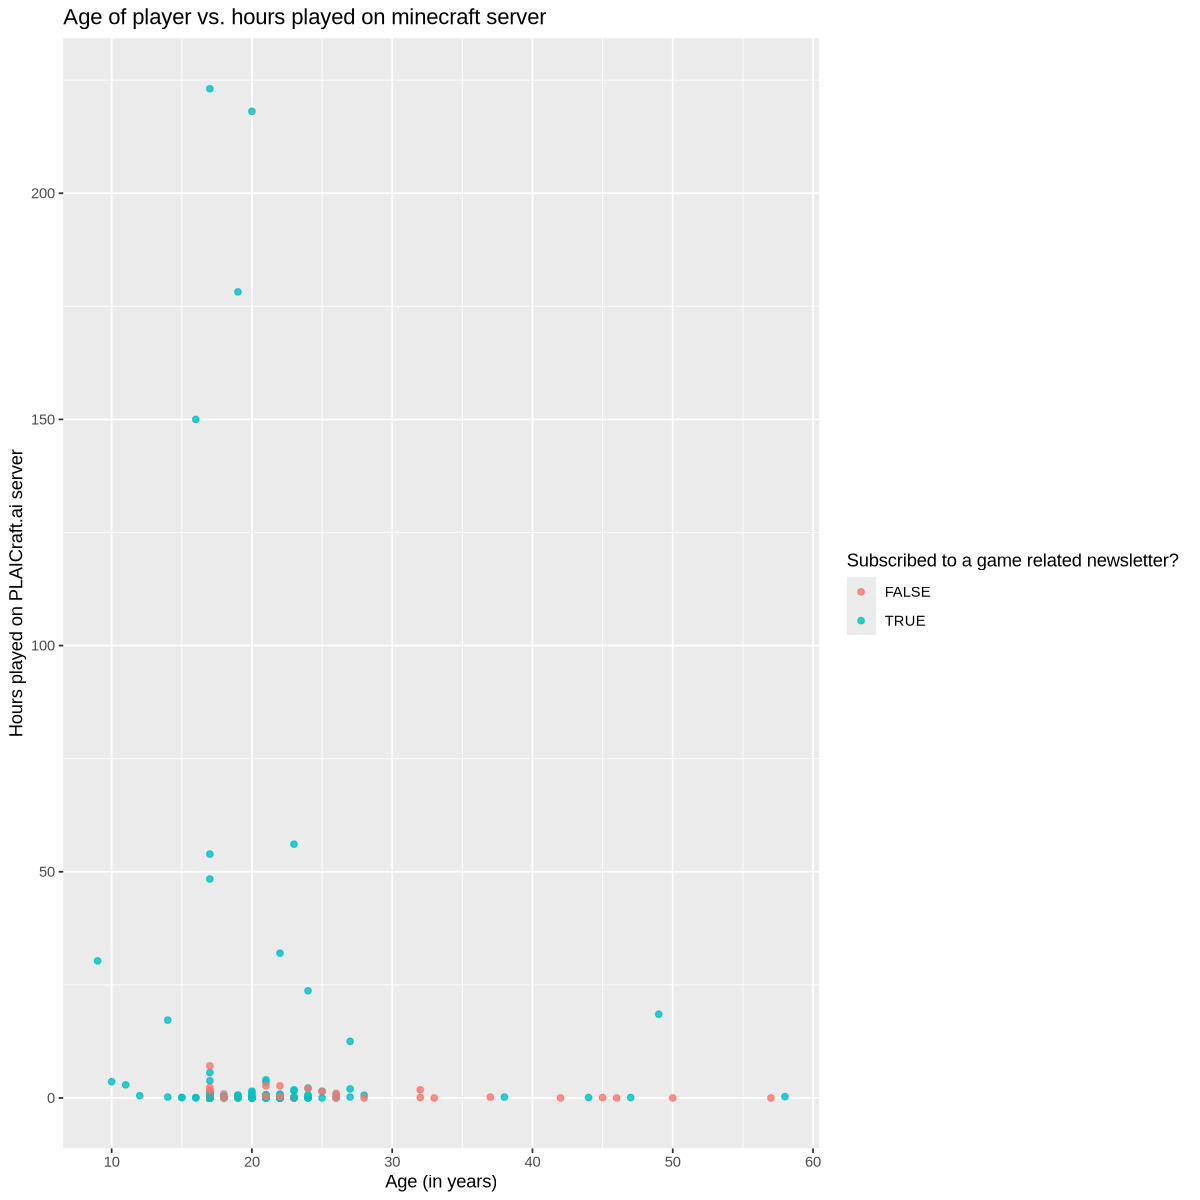

In [8]:
# plot of age on the x-axis and played_hours on the y-axis, coloured in with "subscribe" variable
options(repr.plot.width = 10, repr.plot.height = 10)
age_to_played_hours_plot <- ggplot(players, aes(x = Age, y = played_hours, color = subscribe)) +
                                geom_point(alpha = 0.8) +
                                labs(title = "Age of player vs. hours played on minecraft server",
                                     x = "Age (in years)",
                                     y = "Hours played on PLAICraft.ai server",
                                     color = "Subscribed to a game related newsletter?")
age_to_played_hours_plot

The exploratory plot with all predictors show clear relationships that could produce meaningful results in prediction: more hours played and younger age are both associated with higher subscription rates. However, from the plots exploring each variable, as well as the plot with all variables, some problems are immediately made evident. These include:
- extreme imbalance and sparsity of data points, made clear through the distribution of hours played
- some potential class imbalance between number of FALSE and TRUE datapoints, made clear through bar plot of subscription status
- the fact that this is a relatively small dataset, meaning the model may overfit the data, which may hinder its ability to make accurate predictions

Most of these problems can be addressed using methods such as centering and scaling, cross validation, resampling, and more.

# 4 | Methods and Plan

A suitable method for my chosen question is the K-NN classification introduced in class. K-NN is appropriate because of the use of two quantitative predictors to predict one categorical type for each new observation. Inherently, K-NN classification has little assumptions, the main requirements being that predictors must be on comparable scales, and classes must be sufficiently balanced for best results.

Limitations and weaknesses include:
- sensitivity to class imbalance (which would likely be a problem in this case)
- inability to predict with irrelevent or differently scaled variables
- not enough data points in a small dataset leading to overfitting, less pattern recognition, and increased sensitivity to class imbalance

Some can be minimized through R functions, such as "step_upsample" or previously discussed standardization methods, but these limitations and weaknesses still need to be considered and discussed.

To compare and select the best model for K-NN classification, we could use taught in-class methods, such as picking and selecting the best parameter "K." This would be done through:
1. Splitting data into training and testing, most likely with a 70-30 train-test split.
2. Further split the training data in order to have a validation set, and another subset of the training set
3. Perform cross-validation, and evaluate its performance using one of the three metrics covered in class
4. Pick the K that has the best performance according to the chosen metric
5. Use that value of K in order to predict the class of any future new observations

This way, we can guarantee to have the best performing value of K for models trained on this dataset.

# 5 | GitHub Repository
https://github.com/nhuang07/dsci_project_8/tree/main